# References
* https://stackabuse.com/converting-strings-to-datetime-in-python/
* https://stackoverflow.com/questions/28033656/finding-most-frequent-values-in-column-of-array-in-sql-alchemy
* https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Determine column names

# Create inspector
inspector = inspect(engine)

# Get column info for measurement table
meas_columns = inspector.get_columns('measurement')
print('measurement columns')
for col in meas_columns:
    print(col['name'], col['type'])

# Get column info for station table
stat_columns = inspector.get_columns('station')
print('\nstation columns')
for col in stat_columns:
    print(col['name'], col['type'])

measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

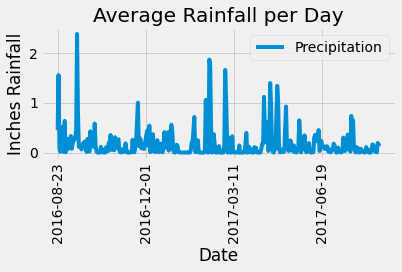

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date_dt = dt.datetime.strptime(last_date, '%Y-%m-%d')
year_ago = last_date_dt - dt.timedelta(days=366)

# Retrieve date and precipitation from database
last_12_prcp = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date >= year_ago)\
                    .all()
# Store in DataFrame
prcp_df = pd.DataFrame(last_12_prcp, columns=['Date', 'Precipitation'])

# Group by date and determine average for each date
# NOTE: The image in the homework key is a line plot of multiple y values for each x value which is unclear. 
prcp_avg = prcp_df.groupby('Date').mean().sort_values(by='Date', ascending=True)

# Plot the data
prcp_avg.plot(ylabel='Inches Rainfall', title='Average Rainfall per Day', rot=90)
plt.tight_layout()
plt.savefig('Images/avgrainfall.png')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(Station).count()
print(f'There are {num_stations} stations in this dataset.')

There are 9 stations in this dataset.


In [15]:
# Determine the most active station in the dataset (defined as the station with the most measurements)
most_active = session.query(Measurement.station, func.count(Measurement.id).label('frqcy')).group_by(Measurement.station).order_by(desc('frqcy')).first()[0]
    
print(f'\nThe most active station in the dataset is {most_active}.')


The most active station in the dataset is USC00519281.


In [16]:
# Calculate the lowest recorded temp, highest recorded temp, and average temp of the most active station
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()[0][0]
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()[0][0]

print(f'The lowest recorded temperature at the most active station is {lowest_temp}.\n'
     f'The highest recorded temperature at the most active station is {highest_temp}.\n'
     f'The average recorded temperature at the most active station is {round(avg_temp, 1)}.')

The lowest recorded temperature at the most active station is 54.0.
The highest recorded temperature at the most active station is 85.0.
The average recorded temperature at the most active station is 71.7.


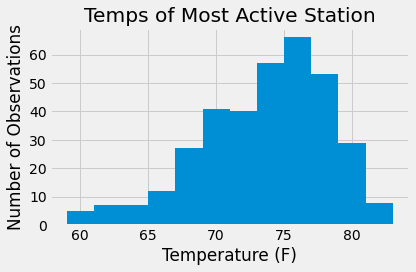

In [31]:
# Query the last 12 months of temperature observation data for the most active station and plot the results as a histogram

# Retrieve data from database
last_12_active = session.query(Measurement.tobs)\
                    .filter(Measurement.date >= year_ago)\
                    .filter(Measurement.station == most_active)\
                    .all()

# Unpack tuples and store in list
active_list = []
for temp in last_12_active:
    active_list.append(temp[0])

# Plot results as a histogram
plt.hist(active_list, bins=12)
plt.ylabel("Number of Observations")
plt.xlabel("Temperature (F)")
plt.title("Temps of Most Active Station")
plt.tight_layout()
plt.savefig('Images/tempsmostactivestation.png')
plt.show()

## Bonus Challenge Assignment

In [18]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
june_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").all()[0][0]
print(f'The average temperature in June is {june_avg}.')

# Put all June temps in a list
june = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
june_all = [temp[0] for temp in june]


# Identify the average temperature in December at all stations across all available years in the dataset.
dec_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").all()[0][0]
print(f'The average temperature in December is {dec_avg}.')

# Put all December temps in a list
dec = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()
dec_all = [temp[0] for temp in dec]

# Independent t-test to determine if the difference in temperature is statistically significant
t_test = stats.ttest_ind(june_all, dec_all)

if t_test.pvalue < 0.05:
    print(f'We reject the null hypothesis that there is no significant difference between the June and Dec. temps.\n'
         f'(pvalue = {t_test.pvalue})')
 
else:
    print(f'We fail to reject the null hypothesis that there is no significant difference between the June and Dec. temps.\n'
        f'(pvalue = {t_test.pvalue})')   


The average temperature in June is 74.94411764705882.
The average temperature in December is 71.04152933421226.
We reject the null hypothesis that there is no significant difference between the June and Dec. temps.
(pvalue = 3.9025129038616655e-191)


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05')[0])

(62.0, 69.57142857142857, 74.0)


In [20]:
# Calculate the tmin, tavg, and tmax for chosen trip dates using the last year of temp data in the database

start_date = '2017-05-10'
end_date = '2017-05-25'

trip_temps = calc_temps(start_date, end_date)[0]
print(f'Trip Dates: {start_date} to {end_date}')
print(f'The minimum temperature is {trip_temps[0]}\n'
      f'The average temperature is {round(trip_temps[1],1)}\n'
      f'The maximum temperature is {trip_temps[2]}')

Trip Dates: 2017-05-10 to 2017-05-25
The minimum temperature is 68.0
The average temperature is 74.9
The maximum temperature is 87.0


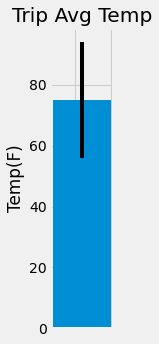

In [34]:
# Plot the results from your previous query as a bar chart. 

plt.figure(figsize=(2, 5))
plt.bar(x=0.2, height = trip_temps[1], yerr=(trip_temps[2]-trip_temps[0]), align='edge')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,
    labelbottom=False)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.tight_layout()
plt.savefig('Images/tripavgtemp.png')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Columns to be selected
sel = [func.sum(Measurement.prcp).label('sum'), 
       Measurement.station, 
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation]

# Pull data from the database
rainfall_station = session.query(*sel)\
                            .group_by(Measurement.station)\
                            .filter(Measurement.station == Station.station)\
                            .filter(Measurement.date >= start_date)\
                            .filter(Measurement.date <= end_date)\
                            .order_by(desc('sum'))\
                            .all()

# Store data in dataframe
rain_station_df = pd.DataFrame(rainfall_station, columns=['Total Rainfall (in)', 
                                                          'Station ID', 
                                                          'Station Name', 
                                                          'Latitude', 
                                                          'Longitude', 
                                                          'Elevation'])
rain_station_df

,Total Rainfall (in),Station ID,Station Name,Latitude,Longitude,Elevation
0,6.94,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,1.74,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,1.61,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,1.40,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,0.51,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,0.44,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# Calculate the daily normals for trip dates

# Create list of dates for trip
dates = pd.date_range(start=start_date, end=end_date)

# Save a list of month/day strings
normals_dates = [date.strftime('%m-%d') for date in dates]

# Save a list of tuples of the normals for each date
normals = [daily_normals(date)[0] for date in normals_dates]
normals

[(64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_df = pd.DataFrame(dates, columns=['Date'])
normals_df = pd.DataFrame(normals, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
normals_indexed = pd.merge(dates_df, normals_df, left_index=True, right_index=True).set_index('Date')
normals_indexed

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-05-10,64.0,73.315789,78.0
2017-05-11,65.0,73.611111,79.0
2017-05-12,65.0,73.137931,79.0
2017-05-13,67.0,73.142857,79.0
2017-05-14,63.0,73.892857,80.0
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0


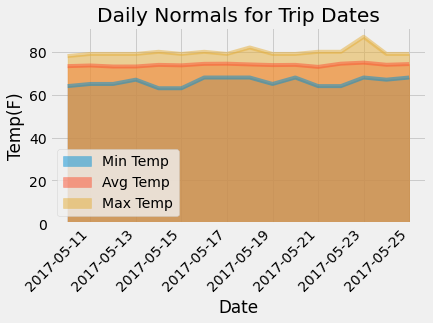

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
normals_indexed.plot.area(stacked=False, rot=45, x_compat=True, ylabel='Temp(F)', title='Daily Normals for Trip Dates')
plt.tight_layout
plt.savefig('Images/tripdailynormals.png')
plt.show()